# Conditional Flow Matching

This notebook is a self-contained example of conditional flow matching. We implement a number of different simulation-free methods for learning flow models. They differ based on the interpolant used and the loss function used to train them.

In this notebook we implement 5 models that can map from a source distribution $q_0$ to a target distribution $q_1$:
* Conditional Flow Matching (CFM)
    * This is equivalent to the basic (non-rectified) formulation of "Flow Straight and Fast: Learning to Generate and Transfer Data with Rectified Flow" [(Liu et al. 2023)](https://openreview.net/forum?id=XVjTT1nw5z)
    * Is similar to "Stochastic Interpolants" [(Albergo et al. 2023)](https://openreview.net/forum?id=li7qeBbCR1t) with a non-variance preserving interpolant.
    * Is similar to "Flow Matching" [(Lipman et al. 2023)](https://openreview.net/forum?id=PqvMRDCJT9t) but conditions on both source and target.
* Optimal Transport CFM (OT-CFM), which directly optimizes for dynamic optimal transport
* Schrödinger Bridge CFM (SB-CFM), which optimizes for Schrödinger Bridge probability paths
* "Building Normalizing Flows with Stochastic Interpolants" [(Albergo et al. 2023)](https://openreview.net/forum?id=li7qeBbCR1t) this corresponds to "VP-CFM" in our README referring to its variance preserving properties.
* "Action Matching: Learning Stochastic Dynamics From Samples" [(Neklyudov et al. 2022)](https://arxiv.org/abs/2210.06662)

Note that this Flow Matching is different from the Generative Flow Network Flow Matching losses. Here we specifically regress against continuous flows, rather than matching inflows and outflows.

In [1]:
import math
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import ot as pot
import torch
import torchdyn
from torchdyn.core import NeuralODE
from torchdyn.datasets import generate_moons

savedir = "models/8gaussian-moons"
os.makedirs(savedir, exist_ok=True)

In [2]:
# Implement some helper functions


def eight_normal_sample(n, dim, scale=1, var=1):
    m = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(dim), math.sqrt(var) * torch.eye(dim)
    )
    centers = [
        (1, 0),
        (-1, 0),
        (0, 1),
        (0, -1),
        (1.0 / np.sqrt(2), 1.0 / np.sqrt(2)),
        (1.0 / np.sqrt(2), -1.0 / np.sqrt(2)),
        (-1.0 / np.sqrt(2), 1.0 / np.sqrt(2)),
        (-1.0 / np.sqrt(2), -1.0 / np.sqrt(2)),
    ]
    centers = torch.tensor(centers) * scale
    noise = m.sample((n,))
    multi = torch.multinomial(torch.ones(8), n, replacement=True)
    data = []
    for i in range(n):
        data.append(centers[multi[i]] + noise[i])
    data = torch.stack(data)
    return data


def sample_moons(n):
    x0, _ = generate_moons(n, noise=0.2)
    return x0 * 3 - 1


def sample_8gaussians(n):
    return eight_normal_sample(n, 2, scale=5, var=0.1).float()


class MLP(torch.nn.Module):
    def __init__(self, dim, out_dim=None, w=64, time_varying=False):
        super().__init__()
        self.time_varying = time_varying
        if out_dim is None:
            out_dim = dim
        self.net = torch.nn.Sequential(
            torch.nn.Linear(dim + (1 if time_varying else 0), w),
            torch.nn.SELU(),
            torch.nn.Linear(w, w),
            torch.nn.SELU(),
            torch.nn.Linear(w, w),
            torch.nn.SELU(),
            torch.nn.Linear(w, out_dim),
        )

    def forward(self, x):
        return self.net(x)


class GradModel(torch.nn.Module):
    def __init__(self, action):
        super().__init__()
        self.action = action

    def forward(self, x):
        x = x.requires_grad_(True)
        grad = torch.autograd.grad(torch.sum(self.action(x)), x, create_graph=True)[0]
        return grad[:, :-1]


class torch_wrapper(torch.nn.Module):
    """Wraps model to torchdyn compatible format."""

    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, t, x, args=None):
        return self.model(torch.cat([x, t.repeat(x.shape[0])[:, None]], 1))


def plot_trajectories(traj):
    n = 2000
    plt.figure(figsize=(6, 6))
    plt.scatter(traj[0, :n, 0], traj[0, :n, 1], s=10, alpha=0.8, c="black")
    plt.scatter(traj[:, :n, 0], traj[:, :n, 1], s=0.2, alpha=0.2, c="olive")
    plt.scatter(traj[-1, :n, 0], traj[-1, :n, 1], s=4, alpha=1, c="blue")
    plt.legend(["Prior sample z(S)", "Flow", "z(0)"])
    plt.xticks([])
    plt.yticks([])
    plt.show()

### Conditional Flow Matching

First we implement the basic conditional flow matching. As in the paper, we have
$$
\begin{align}
z &= (x_0, x_1) \\
q(z) &= q(x_0)q(x_1) \\
p_t(x | z) &= \mathcal{N}(x | t * x_1 + (1 - t) * x_0, \sigma^2) \\
u_t(x | z) &= x_1 - x_0
\end{align}
$$
When $\sigma = 0$ this is equivalent to zero-steps of rectified flow. We find that small $\sigma$ helps to regularize the problem ymmv.

5000: loss 8.637 time 19.25


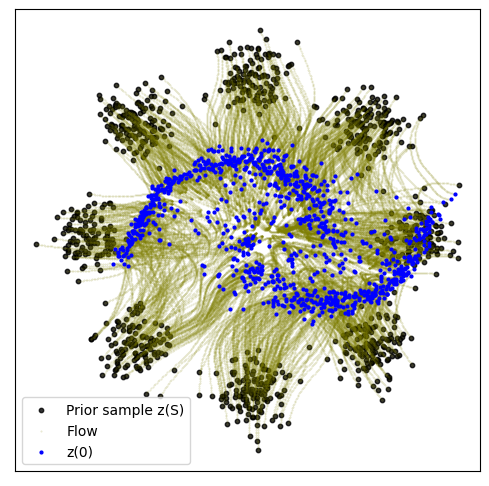

10000: loss 7.626 time 20.70


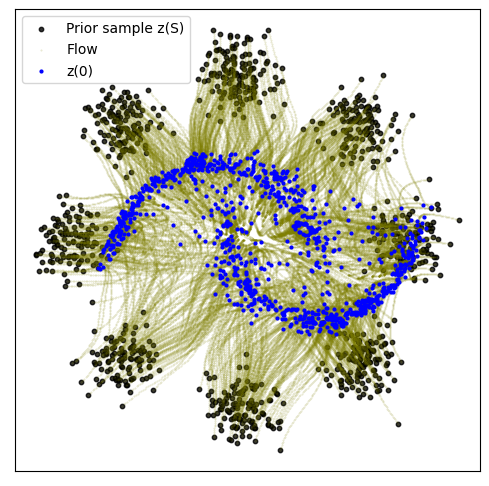

15000: loss 8.372 time 20.31


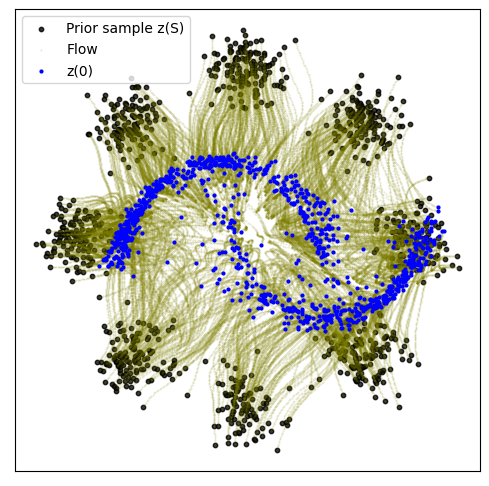

20000: loss 8.815 time 22.02


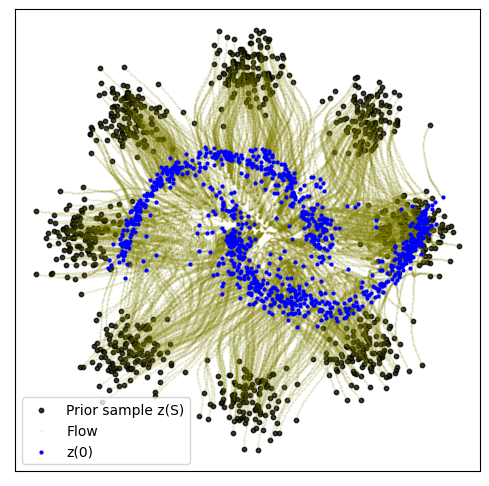

CPU times: user 1min 23s, sys: 431 ms, total: 1min 24s
Wall time: 1min 25s


In [3]:
%%time
sigma = 0.1
dim = 2
batch_size = 256
model = MLP(dim=dim, time_varying=True)
optimizer = torch.optim.Adam(model.parameters())

start = time.time()
for k in range(20000):
    optimizer.zero_grad()
    t = torch.rand(batch_size, 1)
    x0 = sample_8gaussians(batch_size)
    x1 = sample_moons(batch_size)
    mu_t = t * x1 + (1 - t) * x0
    sigma_t = sigma
    x = mu_t + sigma_t * torch.randn(batch_size, dim)
    ut = x1 - x0
    vt = model(torch.cat([x, t], dim=-1))
    loss = torch.mean((vt - ut) ** 2)
    loss.backward()
    optimizer.step()
    if (k + 1) % 5000 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end
        node = NeuralODE(
            torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
        with torch.no_grad():
            traj = node.trajectory(
                sample_8gaussians(1024),
                t_span=torch.linspace(0, 1, 100),
            )
            plot_trajectories(traj)
torch.save(model, f"{savedir}/cfm_v1.pt")

### Optimal Transport Conditional Flow Matching

Next we implement optimal transport conditional flow matching. As in the paper, here we have
$$
\begin{align}
z &= (x_0, x_1) \\
q(z) &= \pi(x_0, x_1) \\
p_t(x | z) &= \mathcal{N}(x | t * x_1 + (1 - t) * x_0, \sigma^2) \\
u_t(x | z) &= x_1 - x_0
\end{align}
$$
where $\pi$ is the joint of an exact optimal transport matrix. We first sample random $x_0, x_1$, then resample according to the optimal transport matrix as computed with the python optimal transport package. We use the 2-Wasserstein distance with an $L^2$ ground distance for equivalence with dynamic optimal transport.

5000: loss 0.151 time 76.63


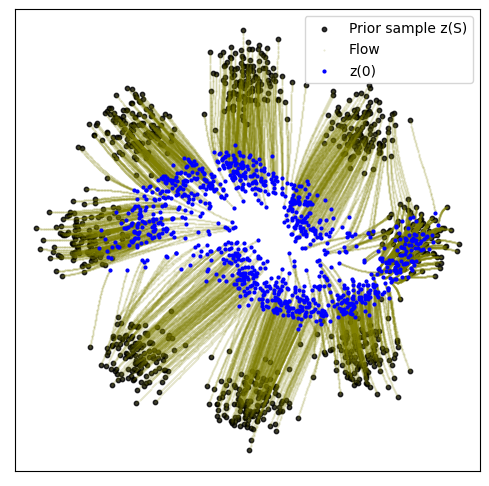

10000: loss 0.144 time 77.74


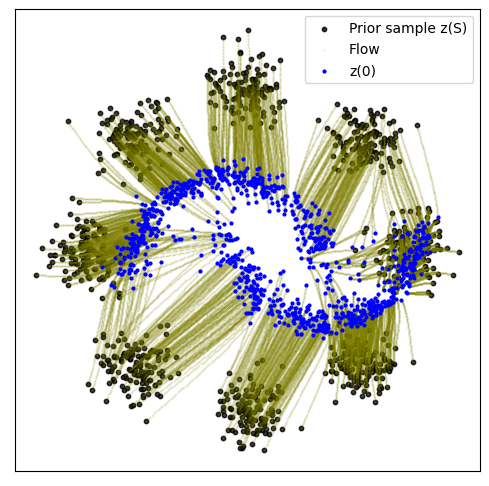

15000: loss 0.131 time 77.89


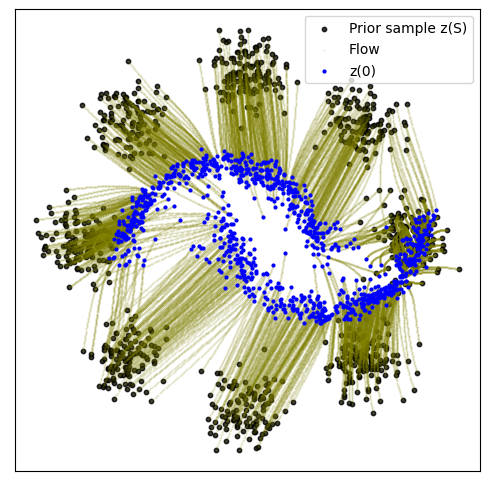

20000: loss 0.139 time 81.60


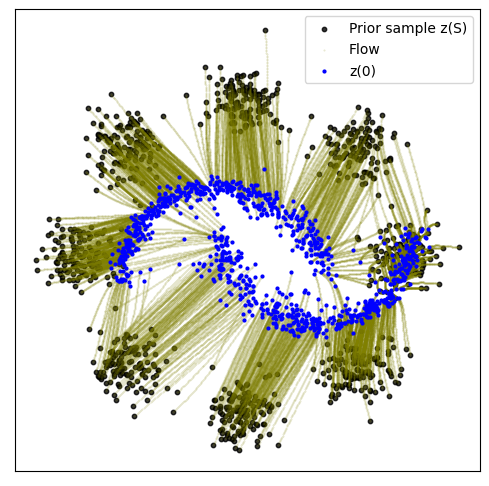

CPU times: user 5min 13s, sys: 343 ms, total: 5min 13s
Wall time: 5min 14s


In [4]:
%%time
sigma = 0.1
dim = 2
batch_size = 256
model = MLP(dim=dim, time_varying=True)
optimizer = torch.optim.Adam(model.parameters())

start = time.time()
for k in range(20000):
    optimizer.zero_grad()
    t = torch.rand(batch_size, 1)
    x0 = sample_8gaussians(batch_size)
    x1 = sample_moons(batch_size)

    # Resample x0, x1 according to transport matrix
    M = torch.cdist(x0, x1) ** 2
    M = M / M.max()
    pi = pot.emd([], [], M.detach().cpu().numpy())
    # Sample random interpolations on pi
    p = pi.flatten()
    p = p / p.sum()
    choices = np.random.choice(pi.shape[0] * pi.shape[1], p=p, size=batch_size)
    i, j = np.divmod(choices, pi.shape[1])
    x0 = x0[i]
    x1 = x1[j]
    # calculate regression loss
    mu_t = x0 * (1 - t) + x1 * t
    sigma_t = sigma
    x = mu_t + sigma_t * torch.randn(batch_size, dim)
    ut = x1 - x0
    vt = model(torch.cat([x, t], dim=-1))
    loss = torch.mean((vt - ut) ** 2)
    loss.backward()
    optimizer.step()
    if (k + 1) % 5000 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end
        node = NeuralODE(
            torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
        with torch.no_grad():
            traj = node.trajectory(
                sample_8gaussians(1024),
                t_span=torch.linspace(0, 1, 100),
            )
            plot_trajectories(traj)
torch.save(model, f"{savedir}/otcfm_v1.pt")

### Schrödinger Bridge Conditional Flow Matching

Next we implement Schrödinger Bridge conditional flow matching. As in the paper, here we have
$$
\begin{align}
z &= (x_0, x_1) \\
q(z) &= \pi_{2 \sigma^2} (x_0, x_1) \\
p_t(x | z) &= \mathcal{N}( x \mid t x_1 + (1 - t) x_0, t(1-t)\sigma^2)\\
u_t(x | z) &= \frac{1-2t}{2t(1-t)}(x - ( t x_1 + (1-t)x_0) ) + (x_1 - x_0)
\end{align}
$$
where $\pi_{2 \sigma^2}$ is the joint of a **Sinkhorn** optimal transport matrix with regularization $2 \sigma^2$. As in OT-CFM We first sample random $x_0, x_1$, then resample according to the optimal transport matrix as computed with the python optimal transport package. We use the 2-Wasserstein distance with an $L^2$ ground distance for equivalence with the probability flow of a Schrödinger Bridge with reference measure $\sigma W$.

Note that the drift $v_\theta(t,x)$ we learn is *not* equivalent to the drift of the stochastic system, instead it is the drift of the equivalent probability flow ODE, however they are related through $p_t(x)$.

Also note that we use a larger $\sigma$ here both for convergence of the Sinkhorn algorithm and to make the differences more visible.

5000: loss 9.885 time 46.10


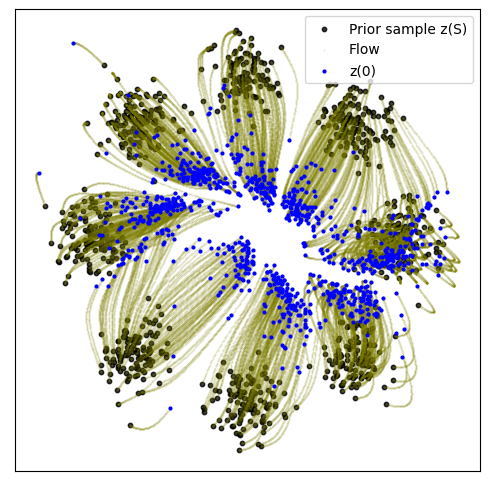

10000: loss 12.561 time 48.92


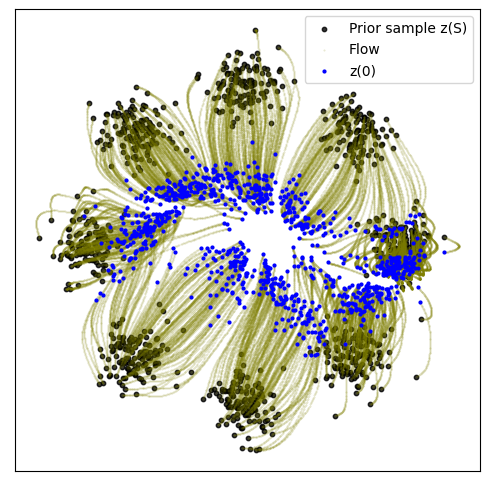

15000: loss 115.912 time 46.97


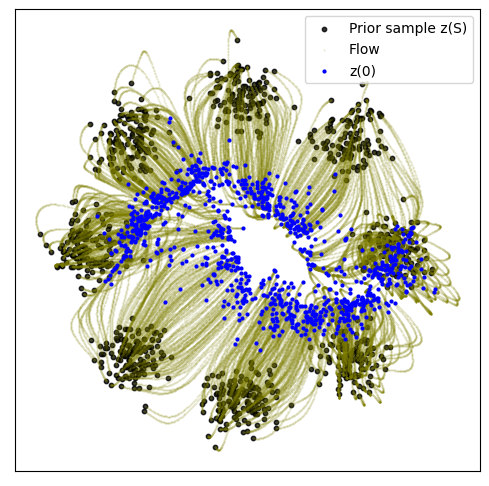

20000: loss 7.889 time 49.25


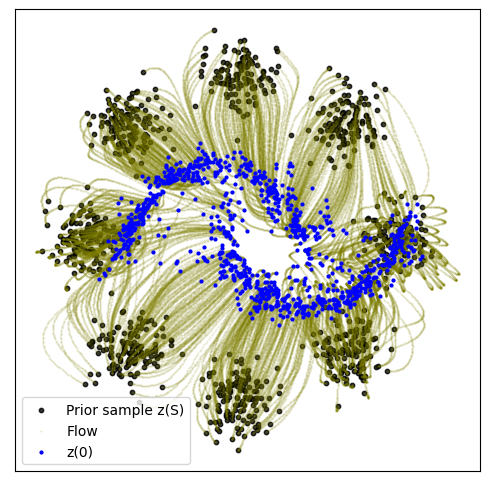

CPU times: user 3min 12s, sys: 308 ms, total: 3min 13s
Wall time: 3min 14s


In [7]:
%%time
sigma = 2
dim = 2
batch_size = 256
model = MLP(dim=dim, time_varying=True)
optimizer = torch.optim.Adam(model.parameters())

start = time.time()
for k in range(20000):
    optimizer.zero_grad()
    t = torch.rand(batch_size, 1)
    x0 = sample_8gaussians(batch_size)
    x1 = sample_moons(batch_size)

    # Resample x0, x1 according to transport matrix
    a, b = pot.unif(x0.size()[0]), pot.unif(x1.size()[0])
    M = torch.cdist(x0, x1) ** 2
    pi = pot.sinkhorn(a, b, M.detach().cpu().numpy(), reg=2 * (sigma**2))
    # Sample random interpolations on pi
    p = pi.flatten()
    p = p / p.sum()
    choices = np.random.choice(pi.shape[0] * pi.shape[1], p=p, size=batch_size)
    i, j = np.divmod(choices, pi.shape[1])
    x0 = x0[i]
    x1 = x1[j]
    # calculate regression loss
    mu_t = t * x1 + (1 - t) * x0
    sigma_t = sigma * torch.sqrt(t - t**2)
    x = mu_t + sigma_t * torch.randn_like(x0)
    sigma_t_prime_over_sigma_t = (1 - 2 * t) / (2 * t * (1 - t))
    ut = sigma_t_prime_over_sigma_t * (x - mu_t) + x1 - x0
    vt = model(torch.cat([x, t], dim=-1))
    loss = torch.mean((vt - ut) ** 2)
    loss.backward()
    optimizer.step()
    if (k + 1) % 5000 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end
        node = NeuralODE(
            torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
        with torch.no_grad():
            traj = node.trajectory(
                sample_8gaussians(1024),
                t_span=torch.linspace(0, 1, 100),
            )
            plot_trajectories(traj)
torch.save(model, f"{savedir}/sbcfm_v1.pt")

### Stochastic Interpolants (Albergo et al. 2023)

Next we try a variant suggested by Albergo et al. 2023, Stochastic Interpolants. This is an interesting interpolant because it has some variance preservation properties. Note that the authors consider $\sigma = 0$ (i.e. a Dirac around $\mu_t$) but we keep the general form for consistency. We also refer to this $t$ schedule as "Variance Preserving" and call this VP-CFM. The authors also consider optimizing over more general interpolants $I_t = \alpha(t) x_0 + \beta(t) x_1$ with minor constraints. In our notation, we have
$$
\begin{align}
z &= (x_0, x_1) \\
q(z) &= q(x_0)q(x_1) \\
p_t(x | z) &= \mathcal{N}(x | \cos \left (\frac{\pi t}{2}  \right ) x_0 + \sin \left (\frac{\pi t}{2}  \right ) x_1, \sigma^2) \\
u_t(x | z) &= \frac{\pi}{2} \left (\cos (\frac{\pi t}{2}) x_1 - \sin(\frac{\pi t}{2}) x_0 \right )
\end{align}
$$

5000: loss 13.973 time 19.30


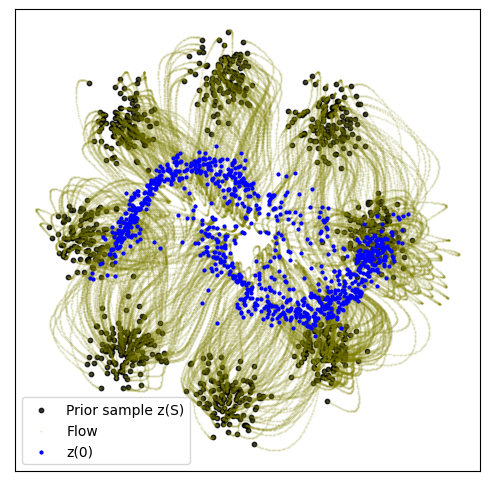

10000: loss 13.678 time 22.26


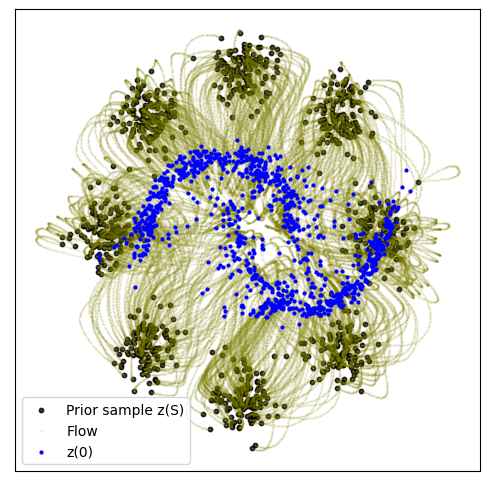

15000: loss 11.986 time 22.31


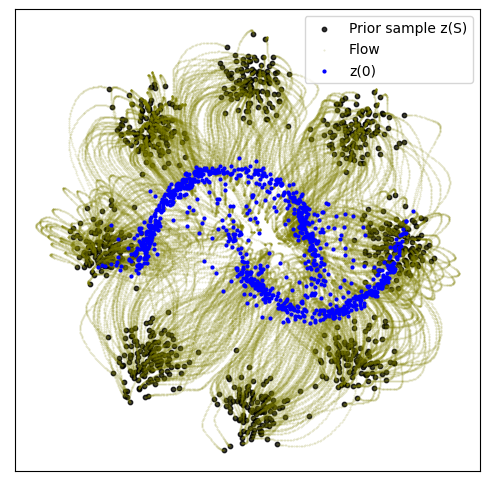

20000: loss 12.184 time 22.19


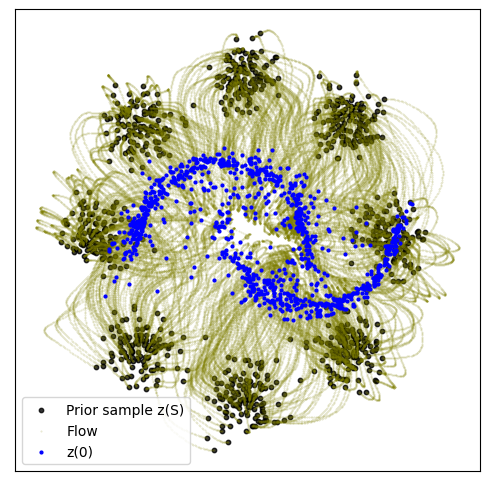

CPU times: user 1min 27s, sys: 423 ms, total: 1min 28s
Wall time: 1min 29s


In [6]:
%%time
sigma = 0.0
dim = 2
batch_size = 256
model = MLP(dim=dim, time_varying=True)
optimizer = torch.optim.Adam(model.parameters())
pi = math.pi

start = time.time()
for k in range(20000):
    optimizer.zero_grad()
    t = torch.rand(batch_size, 1)
    x0 = sample_8gaussians(batch_size)
    x1 = sample_moons(batch_size)
    mu_t = torch.cos(pi / 2 * t) * x0 + torch.sin(pi / 2 * t) * x1
    sigma_t = sigma
    x = mu_t + sigma_t * torch.randn(batch_size, dim)
    ut = pi / 2 * (torch.cos(pi / 2 * t) * x1 - torch.sin(pi / 2 * t) * x0)
    vt = model(torch.cat([x, t], dim=-1))
    loss = torch.mean((vt - ut) ** 2)
    loss.backward()
    optimizer.step()
    if (k + 1) % 5000 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end
        node = NeuralODE(
            torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
        with torch.no_grad():
            traj = node.trajectory(
                sample_8gaussians(1024),
                t_span=torch.linspace(0, 1, 100),
            )
            plot_trajectories(traj)
torch.save(model, f"{savedir}/stochastic_interpolant_v1.pt")

### Action Matching (Neklyudov et al. 2022)

Next we try a variant called action matching. Here we parametrize the velocity field $v_\theta(t, x)$ as $\nabla s_\theta(t, x)$ where $s_\theta(t, x): \mathbb{R} \times \mathbb{R}^d \to \mathbb{R}$ is interpreted as the **action**. This is an interesting parameterization because of its link with optimal transport. Namely this velocity performs instantaneous optimal transport flow over $p_t(x)$. This is slightly different than optimal transport between marginals, but is also quite interesting. Action matching can be summarized in the following way:
$$
\begin{align}
z &= (x_0, x_1) \\
q(z) &= q(x_0)q(x_1) \\
p_t(x | z) &= \mathcal{N}(x | (1-t) x_0 + t x_1, \sigma^2)\\
L_{AM}(\theta) &= s_\theta(0, x_0) - s_\theta(1, x_1) + \frac{1}{2} \| \nabla_x s_\theta(t, x_t)\|^2 + \frac{\partial}{\partial t} s_\theta(t, x_t)
\end{align}
$$
Note that the authors again consider $\sigma = 0$ (i.e. a Dirac around $\mu_t$) but we keep the general form for consistency assuming that $\mathcal{N}(x | \mu_t, 0)$ is a degenerate Dirac centered at $\mu_t$. Our standard parameterization seems to be more difficult to fit with this loss (3-layer MLP with width 64 and SELU activations). It's unclear to me why this is the case, but as suggested in their repo using ReLU, Swish, Swish activations works much better.

5000: loss -6.411 time 28.32


/home/mila/a/alexander.tong/.conda/envs/trajectory-inference/lib/python3.10/site-packages/torchdyn/numerics/odeint.py:84: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


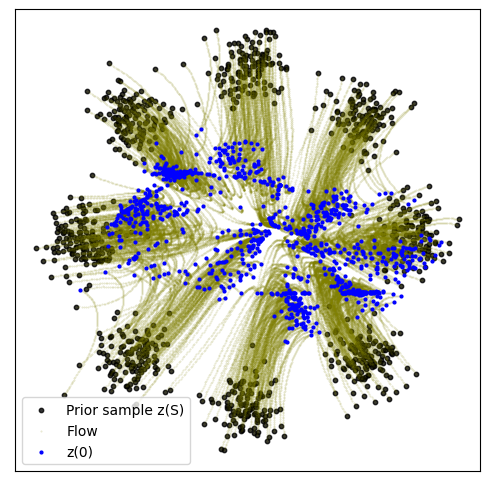

10000: loss -8.341 time 31.28


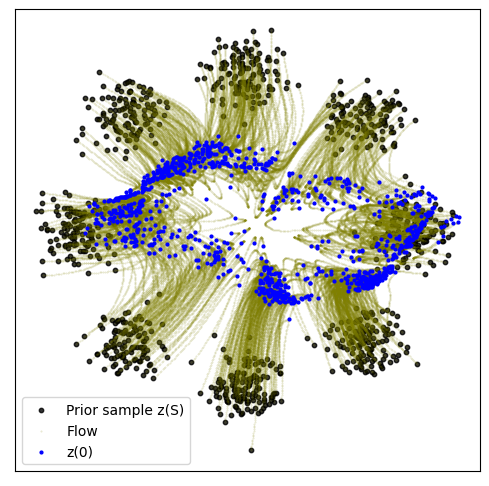

15000: loss -9.163 time 29.67


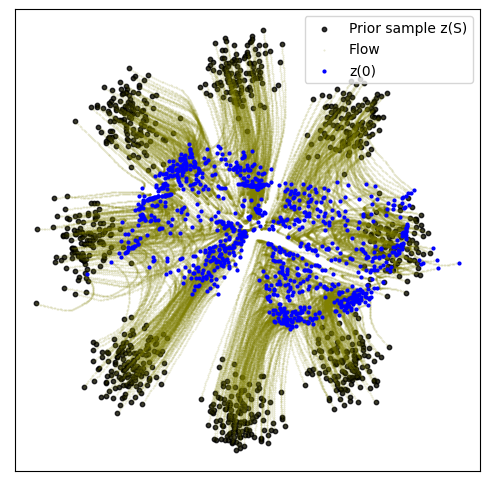

20000: loss -7.023 time 31.09


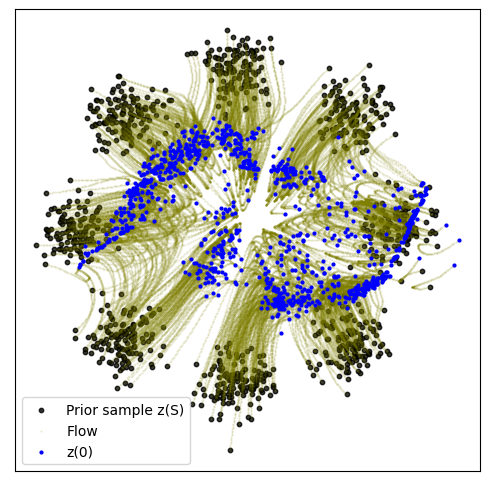

In [7]:
# %%time
dim = 2
batch_size = 256
action = MLP(dim=dim, out_dim=1, time_varying=True, w=64)
model = GradModel(action)
optimizer = torch.optim.Adam(action.parameters())

start = time.time()
for k in range(20000):
    optimizer.zero_grad()
    t = torch.rand(batch_size, 1).requires_grad_(True)
    x0 = sample_8gaussians(batch_size)
    x1 = sample_moons(batch_size)
    xt = (t * x1 + (1 - t) * x0).detach().requires_grad_(True)
    st = torch.sum(action(torch.cat([xt, t], dim=-1)))
    dsdx, dsdt = torch.autograd.grad(st, (xt, t), create_graph=True, retain_graph=True)
    xt.requires_grad, t.requires_grad = False, False
    a0 = action(torch.cat([x0, torch.zeros(batch_size, 1)], dim=-1))
    a1 = action(torch.cat([x1, torch.ones(batch_size, 1)], dim=-1))
    loss = a0 - a1 + 0.5 * (dsdx**2).sum(1, keepdims=True) + dsdt
    loss = loss.mean()
    loss.backward()
    optimizer.step()

    if (k + 1) % 5000 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end
        node = NeuralODE(
            torch_wrapper(model), solver="euler", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
        # with torch.no_grad():
        traj = node.trajectory(
            sample_8gaussians(1024),
            t_span=torch.linspace(0, 1, 100),
        ).detach()
        plot_trajectories(traj)
torch.save(model, f"{savedir}/action_matching_v1.pt")

5000: loss -9.119 time 27.68


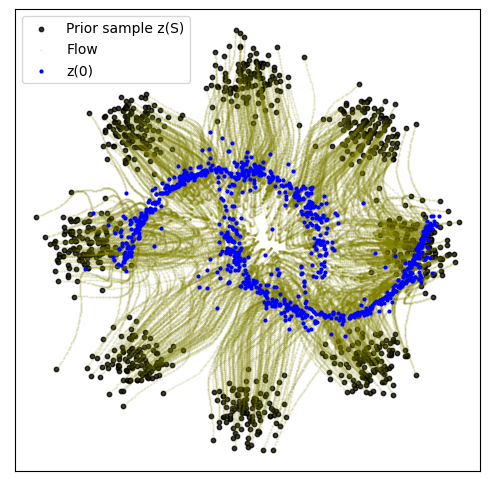

10000: loss -8.490 time 28.98


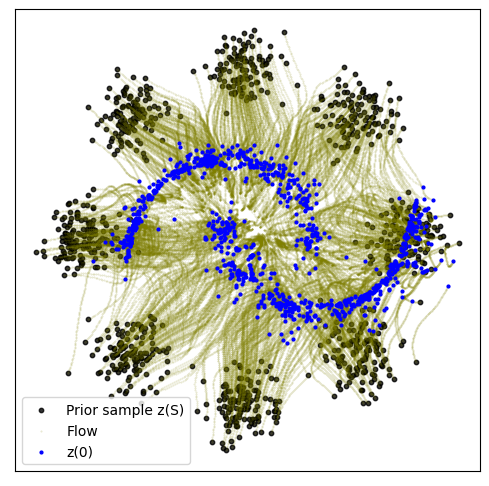

15000: loss -9.187 time 30.50


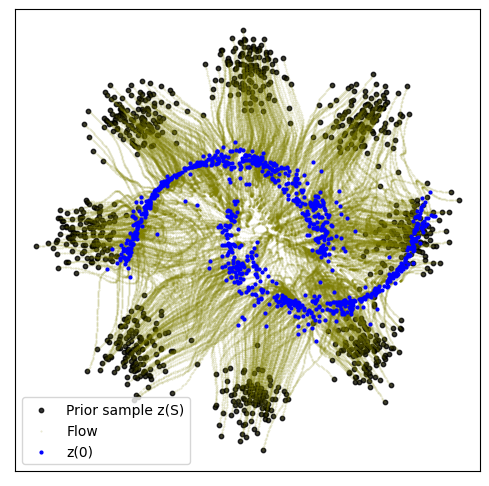

20000: loss -10.552 time 30.47


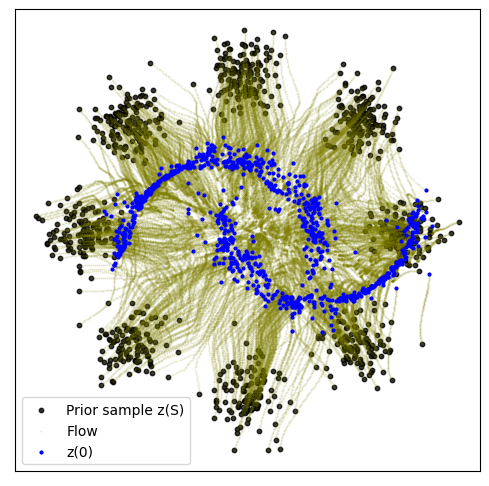

In [8]:
# %%time
class MLP2(torch.nn.Module):
    def __init__(self, dim, out_dim=None, w=64, time_varying=False):
        super().__init__()
        self.time_varying = time_varying
        if out_dim is None:
            out_dim = dim
        self.net = torch.nn.Sequential(
            torch.nn.Linear(dim + (1 if time_varying else 0), w),
            torch.nn.ReLU(),
            torch.nn.Linear(w, w),
            torch.nn.SiLU(),
            torch.nn.Linear(w, w),
            torch.nn.SiLU(),
            torch.nn.Linear(w, out_dim),
        )

    def forward(self, x):
        return self.net(x)


dim = 2
batch_size = 256
action = MLP2(dim=dim, out_dim=1, time_varying=True, w=64)
model = GradModel(action)
optimizer = torch.optim.Adam(action.parameters())

start = time.time()
for k in range(20000):
    optimizer.zero_grad()
    t = torch.rand(batch_size, 1).requires_grad_(True)
    x0 = sample_8gaussians(batch_size)
    x1 = sample_moons(batch_size)
    xt = (t * x1 + (1 - t) * x0).detach().requires_grad_(True)
    st = torch.sum(action(torch.cat([xt, t], dim=-1)))
    dsdx, dsdt = torch.autograd.grad(st, (xt, t), create_graph=True, retain_graph=True)
    xt.requires_grad, t.requires_grad = False, False
    a0 = action(torch.cat([x0, torch.zeros(batch_size, 1)], dim=-1))
    a1 = action(torch.cat([x1, torch.ones(batch_size, 1)], dim=-1))
    loss = a0 - a1 + 0.5 * (dsdx**2).sum(1, keepdims=True) + dsdt
    loss = loss.mean()
    loss.backward()
    optimizer.step()

    if (k + 1) % 5000 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end
        node = NeuralODE(
            torch_wrapper(model), solver="euler", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
        # with torch.no_grad():
        traj = node.trajectory(
            sample_8gaussians(1024),
            t_span=torch.linspace(0, 1, 100),
        ).detach()
        plot_trajectories(traj)
torch.save(model, f"{savedir}/action_matching_swish_v1.pt")